# Large language models (LLMs): Part II

Author: Archit Vasan , including materials on LLMs by Varuni Sastri, and discussion/editorial work by Taylor Childers, Carlo Graziani, Bethany Lusch, and Venkat Vishwanath (Argonne)

Inspiration from the blog posts "The Illustrated Transformer" and "The Illustrated GPT2" by Jay Alammar, highly recommended reading.

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-01-10' at the top-left of the Jupyter notebook.

In [1]:
import os


## LLM training and inference using HuggingFace

In [2]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig

from transformers import pipeline


We will cover  evaluation metrics,as well as safe and responsibilities practices when using LLMs in **Session 8**.

### Training

We can also load in our own dataset and train a model with this data as follows:

In [3]:
# !pip install accelerate -U

In [4]:
from transformers import TextDataset,DataCollatorForLanguageModeling


In [5]:
from transformers import AutoTokenizer,AutoModelForCausalLM

from transformers import Trainer, TrainingArguments


## What is going on below the hood?

Today we will take a closer look at how the model is designed to deal with language.

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F




Image credit: https://jalammar.github.io/illustrated-transformer/

### Let's see attention mechanisms in action!

## Positional encoding

## Training

How does an LLM improve over time?
We want to compare the probabilitiy distribution for each token generated by our model to the ground truths.
Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths.
For example, when translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="https://github.com/SaideepGona/ai-science-training-series/blob/main/05_llm_part2/images/output_target_probability_distributions.png?raw=1" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

In [7]:
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

tensor(0.9119)


Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

In [8]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In this example, we are using cross entropy loss.

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [9]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset.
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [10]:
!wget https://raw.githubusercontent.com/SaideepGona/ai-science-training-series/main/05_llm_part2/dataset/input.txt

--2024-04-08 14:08:26--  https://raw.githubusercontent.com/SaideepGona/ai-science-training-series/main/05_llm_part2/dataset/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-04-08 14:08:26 (19.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [11]:

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(data, block_size, batch_size, device):

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block:
* MultiHeadAttention
* FeedForward Network

In [12]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [14]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM.
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [15]:
# data loading
def get_batch(data, block_size, batch_size, device):

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_iters, data, block_size, batch_size, device):
    out = {}
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, y = get_batch(data, block_size, batch_size, device)
        logits, loss = model(X, y)
        losses[k] = loss.item()
    model.train()
    return losses.mean()

In [16]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------


model = LanguageModel()
model.cuda()

perplexity = {
    "training":[],
    "validation":[]
}

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

for iter in range(max_iters):

  X,y = get_batch(train_data, block_size, batch_size, device)

  # forward pass
  logits, loss = model(X, targets=y)

  # backward pass calculates gradients
  loss.backward()

  # take one step with these gradients
  optimizer.step()

  # resets the gradients
  optimizer.zero_grad()

  if iter % eval_interval == 0:
    print(iter)
    perplexity["training"].append(float(torch.exp(estimate_loss(model, eval_iters, train_data, block_size, batch_size, device)).numpy()))
    perplexity["validation"].append(float(torch.exp(estimate_loss(model, eval_iters, val_data, block_size, batch_size, device)).numpy()))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

<Axes: title={'center': 'Training accuracy'}>

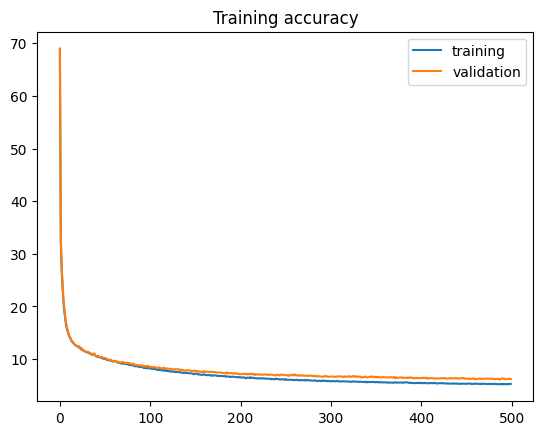

In [17]:
import pandas as pd

perplexity_df = pd.DataFrame(perplexity)

perplexity_df.plot(y = ["training", "validation"], title="Training perplexity")

2. Run the same training loop but modify one of the hyperparameters from this list:

In [22]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 2

max_iters = 5000

perplexity = {}

for n_layer in [1,2,3,4,5]:

  perplexity["training_"+str(n_layer)] = []
  perplexity["validation_"+str(n_layer)] = []

  model = LanguageModel()
  model.cuda()

  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

  for iter in range(max_iters):

    X,y = get_batch(train_data, block_size, batch_size, device)

    # forward pass
    logits, loss = model(X, targets=y)

    # backward pass calculates gradients
    loss.backward()

    # take one step with these gradients
    optimizer.step()

    # resets the gradients
    optimizer.zero_grad()

    if iter % eval_interval == 0:
      print(iter)
      perplexity["training_"+str(n_layer)].append(float(torch.exp(estimate_loss(model, eval_iters, train_data, block_size, batch_size, device)).numpy()))
      perplexity["validation_"+str(n_layer)].append(float(torch.exp(estimate_loss(model, eval_iters, val_data, block_size, batch_size, device)).numpy()))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

<Axes: title={'center': 'Training perplexity'}>

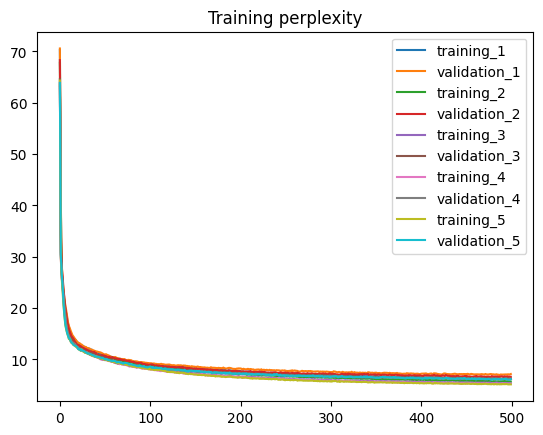

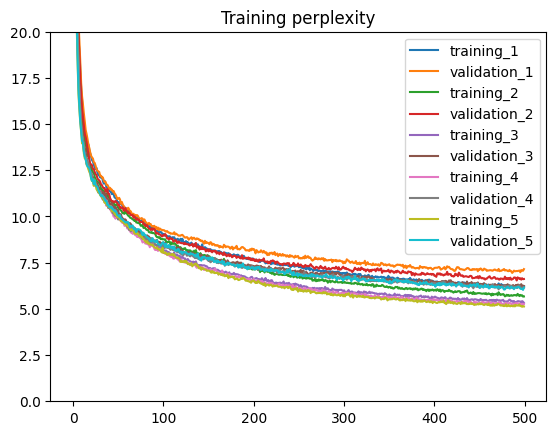

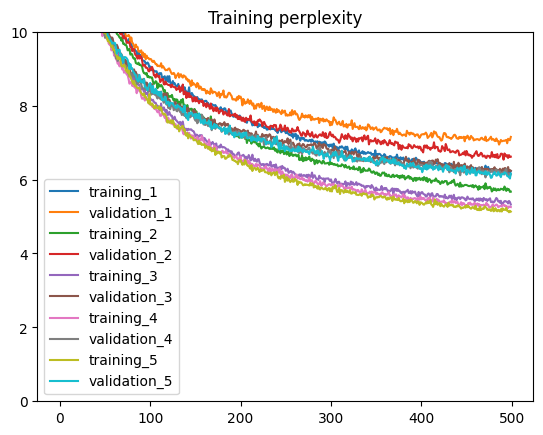

In [25]:
perplexity_df = pd.DataFrame(perplexity)

perplexity_df.plot(y = list(perplexity.keys()), title="Training perplexity")

perplexity_df.plot(y = list(perplexity.keys()), title="Training perplexity", ylim=[0,20])

perplexity_df.plot(y = list(perplexity.keys()), title="Training perplexity", ylim=[0,10])

### Description of performance

It looks like as the number of layers increases, so too does the perplexity improve, but with diminishing returns in the validation set.